# Analysis of Covid-19 data

Load main libraries...

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import re
import sys
import time
import yaml
import dateutil.parser
from datetime import date, datetime, timedelta
from pprint import pprint as pp
import numpy as np
import pandas as pd

from pyathena import connect
from elasticsearch import Elasticsearch

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import matplotlib.dates as mdates
import zipfile

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sys.path.insert(0, r'..')

In [103]:
# Local libraries
from src.config import DATA_FOLDER
from src.utils import plot_stacked_bar

In [3]:
# Main data sources
GLOBAL_CONF = 'global-src-confirmed.csv'
GLOBAL_DEATHS = 'global-src-deaths.csv'
GLOBAL_REC = 'global-src-recovered.csv'

df_glo_conf = pd.read_csv(DATA_FOLDER.joinpath(GLOBAL_CONF))
df_glo_deaths = pd.read_csv(DATA_FOLDER.joinpath(GLOBAL_DEATHS))
df_glo_rec = pd.read_csv(DATA_FOLDER.joinpath(GLOBAL_REC))

print(f"Confirmed shape: {df_glo_conf.shape}")
print(f"Deaths shape: {df_glo_deaths.shape}")
print(f"Recovered shape: {df_glo_rec.shape}")

Confirmed shape: (258, 76)
Deaths shape: (258, 76)
Recovered shape: (244, 76)


In [4]:
df_glo_conf.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8


In [5]:
# Capture relevant columns for the analysis...
is_date = re.compile(r'[\d]{1,2}/[\d]{1,2}/[\d]{1,4}')
date_columns = [k for k in df_glo_conf.columns if is_date.match(k)]
columns2extract = ['Country/Region', *date_columns]
print(f"Columns selected: {columns2extract[:2]} ...")

# Transform string dates to datetime...
updated_indexes = [dateutil.parser.parse(k) for k in date_columns]

Columns selected: ['Country/Region', '1/22/20'] ...


In [6]:
# Select columns and transpose to date as index
df_global_confirmed = df_glo_conf.loc[:, columns2extract].groupby('Country/Region').sum().transpose()
df_global_deaths = df_glo_deaths.loc[:, columns2extract].groupby('Country/Region').sum().transpose()
df_global_recovered = df_glo_rec.loc[:, columns2extract].groupby('Country/Region').sum().transpose()

# Update indices to datetime format
df_global_confirmed.index = updated_indexes
df_global_deaths.index = updated_indexes
df_global_recovered.index = updated_indexes

In [7]:
df_global_confirmed.tail(3)

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
2020-03-31,174,243,716,376,7,7,1054,532,4559,10180,...,645,664,25481,338,172,135,212,119,35,8
2020-04-01,237,259,847,390,8,7,1054,571,4862,10711,...,794,814,29865,338,181,143,218,134,36,8
2020-04-02,273,277,986,428,8,9,1133,663,5116,11129,...,897,1024,34173,350,205,146,233,161,39,9


In [13]:
# Pack the datasets together
global_dict = {
    'confirmed': df_global_confirmed,
    'deaths': df_global_deaths,
    'recovered': df_global_recovered,
}

In [14]:
countries_list = global_dict['confirmed'].columns

In [93]:
def get_country_from_dict(data_dict, country='Spain'):
    sections = ['confirmed', 'deaths', 'recovered']
    
    final_data = {}
    if country == 'all':
        for section in sections:
            selection = data_dict[section].sum(axis=1)
            selection.name = section
            final_data[section] = selection
    else:
        for section in sections:
            selection = data_dict[section].loc[:, country]
            selection.name = section
            final_data[section] = selection
    
    return pd.concat(final_data.values(), axis=1)

In [16]:
# Load widgets
from ipywidgets import *

In [73]:
def totals_plot(country, default=None, logScaleY=False, baseline=10):
    if default:
        country = 'Spain'
    df = get_country_from_dict(global_dict, country)
    df = df[df['confirmed'] > baseline]
    
    fig, ax = plt.subplots(figsize=(16, 8), ncols=1)
    ax.plot('confirmed', data=df, marker='', color='blue', linewidth=2, linestyle='dashed', label="Confirmed")
    ax.plot('deaths', data=df, marker='', color='red', linewidth=2, label="Deaths")
    ax.plot('recovered', data=df, marker='', color='olive', linewidth=2, label="Recovered")
    ax.grid(color='grey', linestyle='-', linewidth=0.5)
    ax.tick_params(axis='x', rotation=65)
    
    if logScaleY:
        ax.set_yscale('log')
        title = f"{country} (Log scale)"
    else:
        title = f"{country} (Linear scale)"
    
    ax.legend()
    ax.set_title(title, fontsize=24);

In [74]:
# Plot totals for selected country. (Deactivate default for other countries)
interact(totals_plot, country=countries_list, default=True, baseline=(0,100));

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

In [79]:
def daily_plot(country, default=None, baseline=10):
    if default:
        country = 'Spain'
    df = get_country_from_dict(global_dict, country)
    df = df[df['confirmed'] > baseline]
    
    # Get the new cases per day
    df = df.diff(1)
    
    column = [('confirmed', 'blue'), ('deaths', 'red'), ('recovered', 'green')]
    fig, ax = plt.subplots(figsize=(16, 4), ncols=3)     # , sharey='all'
    
    for idx, x in enumerate(ax):
        x.bar(df.index, df[column[idx][0]], color=column[idx][1])
        x.grid(color='grey', linestyle='-', linewidth=0.5)
        x.set_title(f"{country} {column[idx][0]}", fontsize=16);
        x.tick_params(axis='x', rotation=75)
        x.set_xlabel("Date")

In [86]:
interact(daily_plot, country=countries_list, default=True, baseline=(0,100));

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

## World Totals

In [104]:
df = get_country_from_dict(global_dict, 'all')
df['confirmed'] = df.apply(lambda x: x.confirmed - x.deaths - x.recovered, axis=1)

In [127]:
series_labels = ['deaths', 'recovered', 'confirmed']
data = [df.values[:, 1], df.values[:, 2], df.values[:, 0]]
category_labels = [k.strftime("%Y-%d-%m") for k in df.index.tolist()]

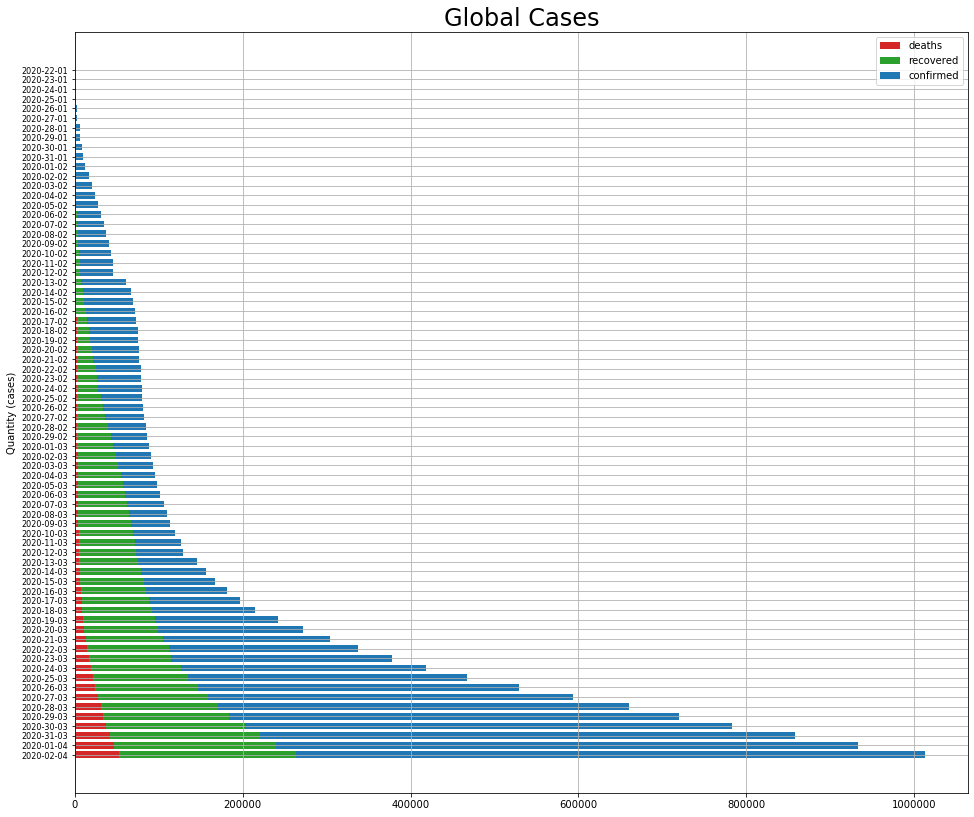

In [155]:
plot_stacked_bar(data, series_labels, category_labels=category_labels, orientation='horizontal',
                 show_values=False, value_format="{:.0f}", plotsize=(16, 14), reverse=True,
                 colors=['tab:red', 'tab:green', 'tab:blue'],
                 y_label="Quantity (cases)", rotation=75, title="Global Cases"
)

## Progression from +n cases

In [81]:
# Set parameters
TOP_SELECTED = 20

# Retrieve countries with top number of confirmed cases:
top_countries = global_dict['confirmed'].iloc[-1, :].sort_values(ascending=False)[:TOP_SELECTED].index

# Retrieve data for those countries
df_top = {
    'confirmed': df_global_confirmed.loc[:, top_countries],
    'deaths': df_global_deaths.loc[:, top_countries],
    'recovered': df_global_recovered.loc[:, top_countries],
}

In [82]:
# Normalize starting point as per selected threshold
def normalize_data(df, threshold=50, margin=25):
    max_day = 0
    processing = {}
    recompute = []
    removed = []
    
    for country in df.columns:
        processing[country] = df[country][df[country] >= threshold]
        if processing[country].empty:
            del processing[country]
            removed.append(country)
            continue
        if processing[country][0] >= threshold * 2:
            recompute.append(country)

        new_index = np.arange(len(processing[country].index))
        processing[country].index = new_index
        if new_index[-1] > max_day:
            max_day = new_index[-1]

    if recompute:
        # Adjust series that may have missing values or start for a very high number
        countries_within_threshold = [c for c in df.columns if c not in [*recompute, *removed]]
        df_top = pd.concat(processing.values(), axis=1)

        for r in recompute:
            find_point = processing[r][0]
            m = (df_top[countries_within_threshold] > find_point - margin) | \
                (df_top[countries_within_threshold] > find_point + margin)
            initial_row = m.sum(axis=1).to_numpy().nonzero()[0][0]
            processing[r].index = np.arange(initial_row, len(processing[r].index) + initial_row)

    return pd.concat(processing.values(), axis=1)

#### Progression from +50 cases

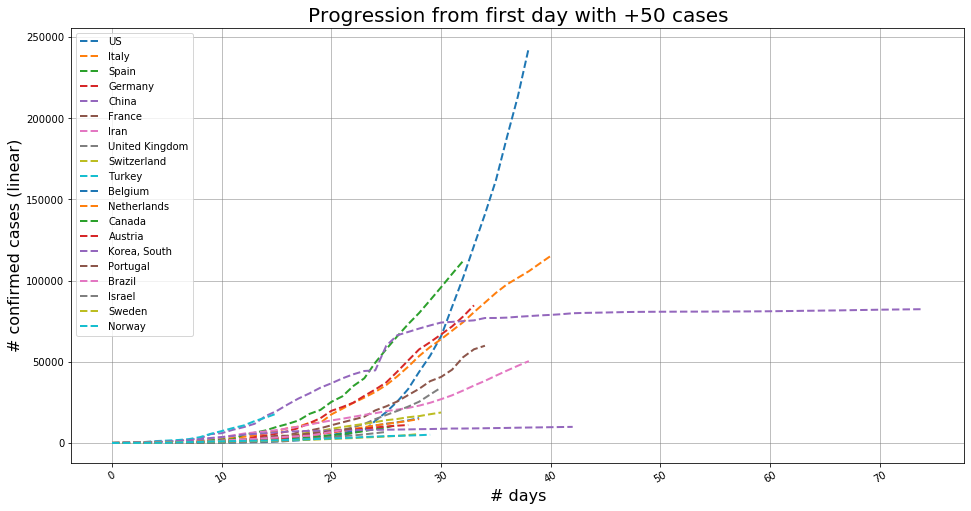

In [83]:
THRESHOLD = 50
df_normalized_50 = normalize_data(df_top['confirmed'], threshold=THRESHOLD, margin=25)

fig, ax = plt.subplots(figsize=(16, 8), ncols=1)

for c in df_normalized_50.columns:
    ax.plot(c, data=df_normalized_50, marker='', linewidth=2, linestyle='dashed', label=c)
    
ax.grid(color='grey', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', rotation=30)
ax.set_xlabel('# days', fontsize=16)
ax.set_ylabel('# confirmed cases (linear)', fontsize=16)
ax.legend()
ax.set_title(f"Progression from first day with +{THRESHOLD} cases", fontsize=20);

## Progression from +1k cases

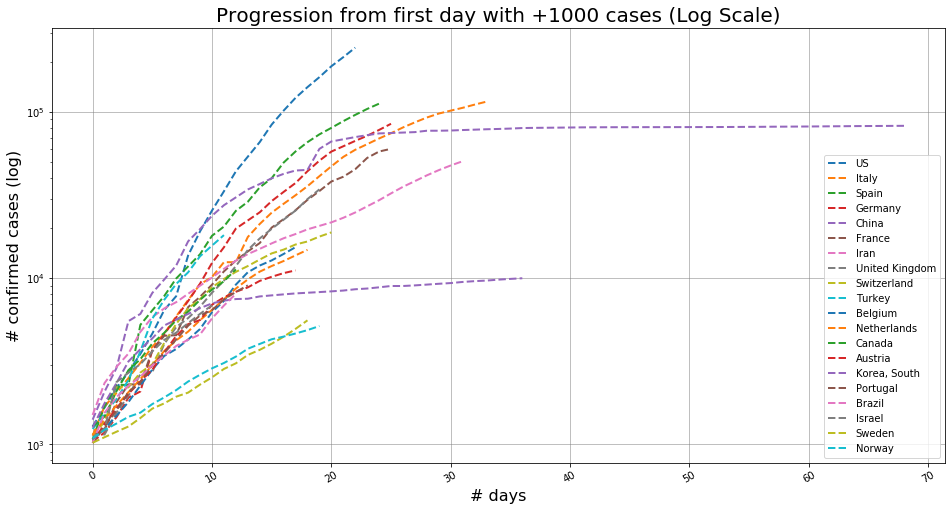

In [84]:
threshold = int(1e3)
df_normalized_1k = normalize_data(df_top['confirmed'], threshold=threshold, margin=25)

fig, ax = plt.subplots(figsize=(16, 8), ncols=1)

for c in df_normalized_1k.columns:
    ax.plot(c, data=df_normalized_1k, marker='', linewidth=2, linestyle='dashed', label=c)
ax.grid(color='grey', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', rotation=30)
ax.set_yscale('log')
ax.set_xlabel('# days', fontsize=16)
ax.set_ylabel('# confirmed cases (log)', fontsize=16)
ax.legend()
ax.set_title(f"Progression from first day with +{threshold} cases (Log Scale)", fontsize=20);

In [85]:
cases_array = [10, 50, 100, 500, 1000, 5000]
modes = ['confirmed', 'deaths', 'recovered']

In [50]:
@interact(ncases=cases_array, mode=modes, logScaleY=True)
def country_plot(ncases, mode, logScaleY=True):
    
    df_normalized = normalize_data(df_top[mode], threshold=ncases, margin=25)

    fig, ax = plt.subplots(figsize=(16, 8), ncols=1)

    for c in df_normalized.columns:
        ax.plot(c, data=df_normalized, marker='', linewidth=2, linestyle='dashed', label=c)
    ax.grid(color='grey', linestyle='-', linewidth=0.5)
    ax.tick_params(axis='x', rotation=30)
    
    ax.set_xlabel('# days', fontsize=16)
    ax.set_ylabel('# confirmed cases (log)', fontsize=16)
    ax.legend()
    
    if logScaleY:
        ax.set_yscale('log')
        scale_str = 'Log scale'
    else:
        scale_str = 'Linear scale'
    ax.set_title(f"Progression: {mode} cases from 1st day with +{ncases} cases ({scale_str})", fontsize=20);

interactive(children=(Dropdown(description='ncases', options=(10, 50, 100, 500, 1000, 5000), value=10), Dropdo…